In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import pandas as pd
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
from pathlib import Path
from tqdm import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# import pmdarima as pm
import numpy as np
import torch.nn.functional as F
from torch import Tensor
from typing import Union, Tuple
import librosa
from IPython.display import Audio, display
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = 'cuda:0'
INPUT_DIR = "drive/MyDrive/data_for_ANN_ML/project/data/" # путь до данных для обучения
VOCAB_SIZE = 20003

In [ ]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
sample_rate = 16_000

In [ ]:
INPUT_SIZE = n_mels
HIDDEN_SIZE = 1024
OUTPUT_SIZE = VOCAB_SIZE
MAX_LENGTH = 40

In [ ]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

Sample Rate: 16000
Shape: (1, 83520)
Dtype: torch.float32
 - Max:      0.775
 - Min:     -0.687
 - Mean:     0.000
 - Std Dev:  0.115

tensor([[ 6.4087e-04, -1.7090e-03, -1.0681e-03,  ...,  3.0518e-05,
          2.1362e-04,  1.7700e-03]])



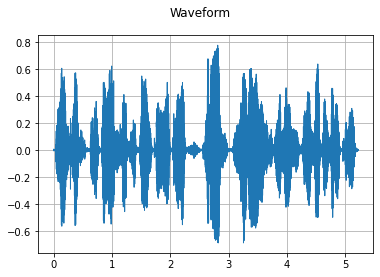

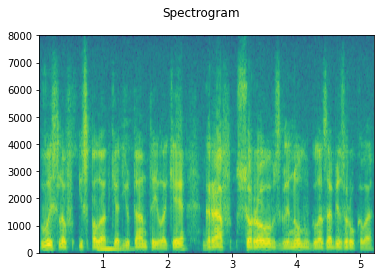

In [ ]:
waveform, sample_rate = torchaudio.load(INPUT_DIR + "train/1.wav")

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

Shape: (1, 128, 164)
Dtype: torch.float32
 - Max:     237.037
 - Min:      0.000
 - Mean:     0.842
 - Std Dev:  5.551

tensor([[[1.5587e-06, 2.3283e-06, 1.0236e-04,  ..., 2.2212e-05,
          3.2008e-06, 4.0517e-04],
         [1.1725e-05, 1.3005e-06, 1.8191e-04,  ..., 3.2908e-05,
          3.2744e-06, 3.8717e-04],
         [4.6970e-05, 5.0271e-05, 6.0273e-05,  ..., 7.5622e-05,
          1.3582e-04, 4.6378e-04],
         ...,
         [2.0776e-06, 1.6140e-05, 8.3179e-06,  ..., 6.1974e-06,
          6.0875e-06, 8.8993e-06],
         [3.2369e-06, 8.1864e-06, 6.9171e-06,  ..., 4.4984e-06,
          5.7767e-06, 8.7137e-06],
         [4.7712e-06, 3.4339e-06, 3.0394e-06,  ..., 2.1925e-06,
          2.6313e-06, 7.2614e-06]]])



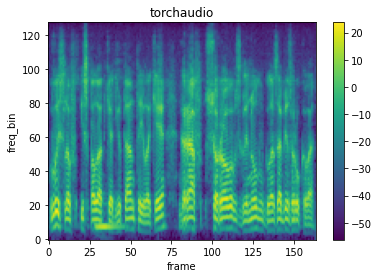

In [ ]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

spec = mel_spectrogram(waveform)

print_stats(spec)
plot_spectrogram(spec[0], title="torchaudio")

Vocabulary building

In [ ]:
a = ord('а')
alphabet = [chr(i) for i in range(a,a+32)]
alphabet.extend([str(i) for i in range(10)]) # little bit extended vocab

alphabet.append(' ')
alphabet.append('u') # as unknown
print(alphabet)

['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', 'u']


In [ ]:
input_chars = []
for string in pd.read_csv("train_labels.csv").to_numpy()[:, 1].reshape(-1):
  input_chars.extend(list(string))
input_chars = set(input_chars)

In [ ]:
class Mapper:
  def __init__(self, alphabet):
    self.len = len(alphabet)
    self.i_to_ch = dict(zip(tuple(range(1, len(alphabet) + 1)), alphabet))

    eng_symbols = [chr(i) for i in range(ord('a'),ord('a')+26)]
    self.ch_to_i = dict(zip(input_chars, [len(alphabet) for _ in range(len(input_chars))]))
    for val, key in enumerate(alphabet):
      self.ch_to_i[key] = val + 1

  def to_int(self, string: str):
    tokens = list(string)
    return [self.ch_to_i[k] for k in tokens]

  def to_ch(self, ind: list):
    return [self.i_to_ch[k] for k in ind]

  def __len__(self):
    return self.len

In [ ]:
vocab = Mapper(alphabet)

In [ ]:
vocab.to_ch(vocab.to_int("urtem артем 123"))

['u', 'u', 'u', 'u', 'u', ' ', 'а', 'р', 'т', 'е', 'м', ' ', '1', '2', '3']

### загрузка датасета и его распаковака

In [ ]:
def create_script():
    
  file_contents = r'''
  #!/usr/bin/env bash

  # Скрипт по загрузке публичных файлов с Облака mail.ru. Поддерживается докачка.
  # v1.0.4 от 2021-05-27
  #
  # ЕСЛИ СКРИПТ НЕ РАБОТАЕТ
  #
  # 1. Убедитесь, что файл доступен публично. Возможна загрузка только публичных файлов.
  # 2. Mail.ru время от времени меняет внутрянку, не очень сильно, но требуется адаптация скрипта.
  #    Если скрипт не работает, просьба сделать работающий форк и скинуть ссылку в комментарии.
  #    Спасибо.
  #
  # КАК ПОЛЬЗОВАТЬСЯ
  #
  # 1. Скачать скрипт.
  # 2. Сделать его исполняемым: 
  # 	chmod +x dl-cloud-mail-ru.sh
  # 3. Скачать файл из облака можно так:
  # 	./dl-cloud-mail-ru.sh ссылка_на_файл локальный_путь
  #    Например (пример рабочий, файл существует, можно потестировать скрипт):
  # 	./dl-cloud-mail-ru.sh https://cloud.mail.ru/public/Y5C8/KRwhz4JHW/linux-5.12.7.tar.xz linux-kernel.tar.xz
  #
  # КАК ПОЛУЧИТЬ ССЫЛКУ НА СКАЧИВАНИЕ ФАЙЛА В ПАПКЕ
  #
  # Если у вас есть ссылка на папку, и нужно скачать файл оттуда:
  #
  # 1. Два раза кликнуть на файл в папке. Появится всплывающее окно с кнопкой "Скачать".
  # 2. В это время в адресной строке браузера будет отображаться ссылка на файл. Это и есть ссылка для скрипта.

  # ENGLISH
  #
  # IMPORTANT: mail.ru sometimes changes internals, not too much, but script must be changed. 
  #
  # If this script does not work:
  #   - see forks, may be there is a fix already,
  #   - if not, please post patch in comments or create a working fork of this gist.
  # Thank you!

  # ИСТОРИЯ И БЛАГОДАРНОСТИ
  #
  # 2021-05-27 дополнена документация
  # 2021-05-26 изменения со стороны mail.ru, плюс теперь определяем url к файлу проще без обращения к api, 
  #            спасибо kerastinell https://gist.github.com/kerastinell/badbd1da6a76a6c77a15661bf0f1e288
  # 2018-06-18 mail.ru изменил формат страницы
  # 2017-09-22 исходная идея: https://novall.net/itnews/bash-skript-dlya-skachivaniya-fajlov-s-mail-ru-cherez-konsol-linux.html

  URL="$1"
  DST_FILE="$2"

  [ -z "$DST_FILE" ] && {
      echo "Syntax: `basename $0` <url> <dst_file>" >&2
      echo "Example: `basename $0` https://cloud.mail.ru/public/BeAr/3s8QfYgLj /path/to/my/file.rar" >&2
      echo "Test: `basename $0` https://cloud.mail.ru/public/Y5C8/KRwhz4JHW/linux-5.12.7.tar.xz linux-5.12.7.tar.xz" >&2
      exit 1
  }

  function getPageInformation() {
    local pageUrl="$1"

    wget --quiet -O - "$pageUrl" | sed -n "/window.cloudSettings/,/};<\/script>/p"
  }

  function ensureFileExists() {
    local pageInformation="$1"

    echo "$pageInformation" |  grep -q '"not_exists"' && {
      echo "Error: file does not exist" >&2
      exit 1
    }
  }

  function extractDownloadUrl() {
    local pageUrl="$1" pageInformation="$2" storageUrl filePath

    storageUrl=$(echo "$pageInformation" | sed -n "/weblink_get/,/]/p" | fgrep -m 1 "url" | cut -d "\"" -f 4)
        filePath=$(echo "$pageUrl" | awk -F '/public/' '{print $2}')

    [ -z "$storageUrl" ] || [ -z "$filePath" ] && {
      echo "Error: failed to extract storage's url or file path" >&2
      exit 1
    }

    echo "$storageUrl/$filePath"
  }

  pageInformation=$(getPageInformation "$URL")
  ensureFileExists "$pageInformation"
  downloadUrl=$(extractDownloadUrl "$URL" "$pageInformation")

  wget --continue --no-check-certificate --referer="$URL" "$downloadUrl" -O "$DST_FILE"'''
  with open('bebra.sh', 'w') as file:
    file.write(file_contents)

create_script()

In [ ]:
!bash bebra.sh https://cloud.mail.ru/public/R65Q/thHoZwEVB data.zip

--2022-05-09 16:16:04--  https://cloclo50.cloud.mail.ru/public/ib565W73zGeeBBwZJoF/g/no/R65Q/thHoZwEVB
Resolving cloclo50.cloud.mail.ru (cloclo50.cloud.mail.ru)... 95.163.51.35
Connecting to cloclo50.cloud.mail.ru (cloclo50.cloud.mail.ru)|95.163.51.35|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://cloclo50.datacloudmail.ru/public/get/7YQS4WdXAjASmcAu7UmsLXdUFzsG8uR1SVN6MeqyXyg7hBa8EwfP6qLy5V5VZ5LrGTgFLg/no/data.zip [following]
--2022-05-09 16:16:05--  https://cloclo50.datacloudmail.ru/public/get/7YQS4WdXAjASmcAu7UmsLXdUFzsG8uR1SVN6MeqyXyg7hBa8EwfP6qLy5V5VZ5LrGTgFLg/no/data.zip
Resolving cloclo50.datacloudmail.ru (cloclo50.datacloudmail.ru)... 95.163.51.35
Connecting to cloclo50.datacloudmail.ru (cloclo50.datacloudmail.ru)|95.163.51.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17024121411 (16G) [application/octet-stream]
Saving to: ‘data.zip’

data.zip              0%[                    ]   5.55M   309K

In [ ]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
!ls

bebra.sh  data.zip  drive  sample_data


In [ ]:
!unzip data.zip

In [ ]:
!ls
!rm -rf data.zip
!ls

bebra.sh  data	data.zip  drive  sample_data
bebra.sh  data	drive  sample_data


### Создание датасета и лоадера

In [ ]:
def load_item(fileid: str, ext: str, path: str) -> Tensor:
    """
    Loads a file from the dataset and returns the raw waveform
    as a Torch Tensor, its sample rate as an integer, and its
    genre as a string.
    """

    # Read wav
    file_audio = os.path.join(path, fileid + "." + ext)
    waveform, sample_rate = torchaudio.load(file_audio)

    return waveform, sample_rate

class dataSet(Dataset):
    _ext_audio = ".wav"

    def __init__(
        self,
        data_set_path: str,
        name: str,
        transforms,
        train_val_split = None,
        labels_file_path = None,
    ) -> None:


        self.data_set_path = data_set_path
        self.file_ext = 'wav'
        self.name = name
        self.transforms = transforms
        self.labels_file_path = labels_file_path

        assert( name in ['train', 'test', 'decode'])

        if self.labels_file_path:
          # создание двумерного массива list(Tensor)
          self.labels = pd.read_csv(labels_file_path).to_numpy()
        else:
          self.labels = None

        fulldir = os.path.join(self.data_set_path)
        self._walker = []
        for fname in os.listdir(fulldir):
          name, ext = os.path.splitext(fname)
          self._walker.append(int(name))

    def __getitem__(self, n: int) -> Tuple[Tensor, int, str]:
        """Load the n-th sample from the dataset.

        Args:
            n (int): The index of the sample to be loaded

        Returns:
            (Tensor, int, str): ``(waveform, sample_rate, label)``
        """
        fileid = str(self._walker[n])
        item = load_item(fileid, self.file_ext, self.data_set_path)
        waveform, sample_rate = item
        # транспоуз нужен потому что у нас melSpectrogram делает 
        # данные неподходящего вида для RNN
        spec = self.transforms(waveform).squeeze().transpose(0, 1)
        if self.labels is not None:
          label = torch.Tensor(vocab.to_int(self.labels[self.labels[:, 0] == self._walker[n], 1][0]))
        else:
          label = torch.Tensor([0])
        return spec, label


    def __len__(self) -> int:
        return len(self._walker)

In [ ]:
def data_pad_loader(data, data_type='train'):
  specs, labels = list(zip(*data))
  input_lengths = [x.shape[0] // 2 for x in specs]
  label_lengths = list(map(len, labels))

  specs = nn.utils.rnn.pad_sequence(specs, batch_first=True).unsqueeze(1).transpose(2, 3)
  labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

  return specs, labels, input_lengths, label_lengths

In [ ]:
transforms = nn.Sequential(
    T.MelSpectrogram(
    sample_rate=sample_rate,
    # n_fft=n_fft,
    # win_length=win_length,
    # hop_length=hop_length,
    # center=True,
    # pad_mode="reflect",
    # power=2.0,
    # norm="slaney",
    # onesided=True,
    n_mels=n_mels,
    # mel_scale="htk",
    ),
)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [ ]:
train_dataset = dataSet('data/train_wavs/', "train", transforms, labels_file_path='data/train_labels.csv')
train_loader = torch.utils.data.DataLoader( train_dataset,
                                      batch_size=20,
                                      shuffle=False,
                                      collate_fn=lambda x: data_pad_loader(x, 'train'),)

In [ ]:
train_dataset[0][1]

tensor([32., 43.,  3.,  9.,  5.,  6., 12., 43., 19.,  1., 11., 15.,  6., 43.,
        15., 43., 24.,  6., 13., 43., 14.,  6., 43., 18., 13.,  6., 31., 43.,
        17.,  1., 18., 18., 11.,  1.,  8.,  1., 19., 29., 43.,  3.,  1., 13.,
        43., 15., 19.,  3.,  6., 19.,  9., 12., 43.,  3.,  9., 12., 29., 32.,
        13., 43.,  9., 14.,  1., 24.,  6., 43.,  3.,  1., 13., 43., 18., 19.,
         1., 14., 20., 19., 43., 18., 14.,  9., 19., 29., 18., 32., 43., 11.,
        15., 25., 13.,  1., 17., 28.])

In [ ]:
from itertools import islice
for i in islice(train_loader, 2):
  print(i[3][0])

90


In [ ]:
len(train_dataset.labels[:, 1].reshape(-1)[0])

129

### MODEL CONSTRUCTING

#### Ready to use wavtovec pretrained ctc

In [ ]:
# !pip3 install numba
# !pip3 install librosa
# !pip install datasets
# !pip install transformers

# import torch
# import librosa
# from datasets import load_dataset
# from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

In [ ]:
# # dataset for pretrained ctc
# def load_item(path_):
#   return librosa.load(path_, sr=16_000)[0]

# class ctc_test_dataset(Dataset):
#   def __init__(self, dir_path, folder_in_archive):
#     super().__init__()

#     self.batch_size = 10
#     self.folder_in_archive = folder_in_archive
#     self.ext = '.wav'
#     self._path = os.path.join(dir_path, self.folder_in_archive)
#     self.fulldir = os.path.join(dir_path, self.folder_in_archive)

#     self._walker = []
#     for fname in os.listdir(self.fulldir):
#       name, ext = os.path.splitext(fname)
#       self._walker.append(name)

#   def __getitem__(self, index):
#     return list(map(load_item, [self.fulldir + self._walker[i] + self.ext for i in range(index * self.batch_size, (index + 1) * self.batch_size)]))
  
#   def __len__(self):
#     return len(self._walker)

In [ ]:
# test_dataset = ctc_test_dataset(INPUT_DIR, 'train/')
# test_dataloader = DataLoader(test_dataset, 1)

In [ ]:
# LANG_ID = "ru"
# MODEL_ID = "jonatasgrosman/wav2vec2-large-xlsr-53-russian"
# SAMPLES = 5

# # test_dataset = load_dataset("common_voice", LANG_ID, split=f"test[:{SAMPLES}]")

# # processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)
# # model = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)

# # Preprocessing the datasets.
# # We need to read the audio files as arrays
# def speech_file_to_array_fn(batch):
#     speech_array, sampling_rate = librosa.load(batch["path"], sr=16_000)
#     batch["speech"] = speech_array
#     batch["sentence"] = batch["sentence"].upper()
#     return batch

# # test_dataset = test_dataset.map(speech_file_to_array_fn)
# # inputs = processor(test_dataset["speech"], sampling_rate=16_000, return_tensors="pt", padding=True)


# with torch.no_grad():
#   for input in test_dataloader:
#     input = processor(input, sampling_rate=16_000, return_tensors="pt", padding=True)
#     logits = model(input.input_values, attention_mask=input.attention_mask).logits

#     predicted_ids = torch.argmax(logits, dim=-1)
#     predicted_sentences = processor.batch_decode(predicted_ids)

#     for i, predicted_sentence in enumerate(predicted_sentences):
#         print("-" * 100)
#         print("Prediction:", predicted_sentence)

#### self written ctc

#### defining model

In [ ]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 

class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)
        
class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

In [ ]:
model = SpeechRecognitionModel(4, 2, 256, len(vocab), n_mels)
model.cuda()

#### setting optimizer, sheduler, criterion

In [ ]:
from torch import optim

In [ ]:
learning_rate = 0.001
epochs = 2


In [ ]:
optimizer = optim.AdamW(model.parameters(), learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
	max_lr=learning_rate,
	steps_per_epoch=int(len(train_loader)),
	epochs=epochs,
	anneal_strategy='linear')

In [ ]:
criterion = nn.CTCLoss(blank=0).to(device)

#### defining decoder

Изощренная штука, будем пожалуй использовать гриди декодер, так как искать еще модель для ctc декодера я не вытяну, а без нее, толку в бим серче не много.

In [ ]:
try:
    import torchaudio.prototype.ctc_decoder
except ModuleNotFoundError:
    try:
        import google.colab

        print(
            """
            To enable running this notebook in Google Colab, install nightly
            torch and torchaudio builds by adding the following code block to the top
            of the notebook before running it:

            !pip3 uninstall -y torch torchvision torchaudio
            !pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/gpu
            """
        )
    except ModuleNotFoundError:
        pass
    raise

In [ ]:
!pip3 uninstall -y torch torchvision torchaudio
!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/gpu

Found existing installation: torch 1.11.0
Uninstalling torch-1.11.0:
  Successfully uninstalled torch-1.11.0
Found existing installation: torchvision 0.12.0
Uninstalling torchvision-0.12.0:
  Successfully uninstalled torchvision-0.12.0
Found existing installation: torchaudio 0.11.0
Uninstalling torchaudio-0.11.0:
  Successfully uninstalled torchaudio-0.11.0
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/gpu
  Using cached torch-1.11.0-cp37-cp37m-manylinux1_x86_64.whl (750.6 MB)
  Using cached torchvision-0.12.0-cp37-cp37m-manylinux1_x86_64.whl (21.0 MB)
  Using cached torchaudio-0.11.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)


In [ ]:
tokens = list(vocab.i_to_ch.values())
tokens.insert(0, 'b')

In [ ]:
from torchaudio.prototype.ctc_decoder import ctc_decoder

LM_WEIGHT = 3.23
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    # lexicon=files.lexicon,
    tokens=tokens,
    # lm=files.lm,
    lexicon = None,


    blank_token = 'b', 
    sil_token = ' ', 
)

ModuleNotFoundError: ignored

In [ ]:
def GreedyDecoder(output, labels, label_lengths, blank_label=0, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    # targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        # targets.append(vocab.i_to_ch(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(vocab.to_ch(decode))
    return decodes#, targets

In [ ]:
''' данная секция предназначается для проверки на переобучиение слишком простым датасетом. '''

# class testmodel_dataset(Dataset):
#   def __init__(self):
#     super().__init__()
#     self.spec = torch.rand(418, 128)
#     self.label = torch.Tensor(vocab.to_int("бебра".upper()))
#   def __getitem__(self, n):
#     return self.spec, self.label
  
#   def __len__(self):
#     return 10

# test_model_dataset = testmodel_dataset()
# test_model_dataloader = torch.utils.data.DataLoader( test_model_dataset,
#                                     batch_size=10,
#                                     shuffle=True,
#                                     collate_fn=lambda x: data_pad_loader(x, 'train'),)

' данная секция предназначается для проверки на переобучиение слишком простым датасетом. '

### треин и инференс модели.

In [ ]:
model.train()
for epoch in range(epochs):
  data_len = len(train_loader.dataset)
  for batch_idx, _data in enumerate(train_loader):
    spectrograms, labels, input_lengths, label_lengths = _data 
    spectrograms, labels = spectrograms.to(device), labels.to(device)

    optimizer.zero_grad()

    output = model(spectrograms)  # (batch, time, n_class)
    output = F.log_softmax(output, dim=2)
    output = output.transpose(0, 1) # (time, batch, n_class)
    loss = criterion(output, labels, input_lengths, label_lengths)
    loss.backward()

    print(f'loss: {loss.item()}')
    print(f'learning_rate: { scheduler.get_lr()}')

    optimizer.step()
    scheduler.step()

    if batch_idx % 500 == 0 or batch_idx == data_len:
      torch.save(model.state_dict(), INPUT_DIR + "model_ctc")
      torch.save(optimizer.state_dict(), INPUT_DIR + "optmi_ctc")
      torch.save(scheduler.state_dict(), INPUT_DIR + "sched_ctc")

    if batch_idx % 100 == 0 or batch_idx == data_len:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(spectrograms), data_len,
        100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
torch.cuda.is_available()

False

In [ ]:
model.load_state_dict(torch.load(INPUT_DIR + "model_ctc"))
optimizer.load_state_dict(torch.load(INPUT_DIR + "optmi_ctc"))
scheduler.load_state_dict(torch.load(INPUT_DIR + "sched_ctc"))

RuntimeError: ignored

In [ ]:
test_dataset = dataSet(INPUT_DIR ,"test", transforms, None)
test_loader = torch.utils.data.DataLoader( test_dataset,
                                      batch_size=1,
                                      shuffle=False,
                                      collate_fn=lambda x: data_pad_loader(x, 'train'))

In [ ]:
model.eval()
for i in test_loader:
  spectrograms, labels, input_lengths, label_lengths = i 
  spectrograms, labels = spectrograms.to(device), labels.to(device)
  output = model(spectrograms)  # (batch, time, n_class)
  output = F.log_softmax(output, dim=2)
  output = output.transpose(0, 1) # (time, batch, n_class)
  decoded_preds = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
  print(decoded_preds)

[['з', 'у', 'м', 'и', 'т', 'с', 'я', ' ', 'с', 'о', 'н', 'е', 'р', 'н', 'у', ' ', 'у', 'с', 'п', 'е', 'л']]
[['е', 'в', 'о', 'т', ' ', 'я', 'о', 'ж', 'е', 'л', 'а', ' ', 'т', 'а', 'н', 'е', ' ', 'в', 'с', 'е', 'п', 'о', 'г', 'и', 'б', 'л', 'и', 'х']]
[['и', 'д', 'е', 'в', 'л', 'я', 'н', ' ', 'с', 'ч', 'е', 'с', 'о', ' ', 'б', 'е', 'с', 'п', 'о', 'к', 'о', 'й', 'е', ' ', 'п', 'о', 'с', 'м', 'о', 'т', 'р', 'е', 'л', ' ', 'н', 'о', ' ', 'б', 'е', 'г', 'у', 'с', 'и', 'х', ' ', 'н', 'о', 'м', 'н', 'а', ' ', 'с', 'т', 'р', 'е', 'ч', 'л', 'ю', 'д', 'е']]
[['е', ' ', 'в', 'е', 'з', 'г', 'о', 'р', 'д', 'о', 'с', 'т', 'и', ' ', 'к', 'а', 'з', 'а', 'л', 'а', ' ', 'и', ' ', 'у', 'д', 'а', ' ', 'к', 'о', 'р', 'о', 'л', 'ю', 'н', 'а', ' ', 'э', 'т', 'е', ' ', 'т', 'в', 'о', 'д', 'ы', ' ', 'н', 'а', 'с', 'у', 'ь', 'м', 'а', 'л', 'и', ' ', 'н', 'а', ' ', 'з', 'о', 'в', 'а', 'л', 'и', 'х', ' ', 'п', 'о', 'д', 'а', 'м', 'у', 'в', 'ы', 'м', 'е', ' ', 'п', 'л', 'а', 'д', 'а', 'н', 'и', 'т', ' ', 'и', ' ',